In [1]:
import pandas as pd
import numpy as np
import itertools
import pickle
import matplotlib
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle


In [2]:
#df-extracted data features
df = pd.read_csv('df_features.csv')
print(df.shape)
df.head()

(40540, 98)


file_name  signal_mean  signal_std  signal_skew  \
0     38359_Rock_music.wav        0.291       0.350        0.553   
1     50194_Rock_music.wav        0.222       0.278        0.990   
2  24275_Hip_hop_music.wav        0.174       0.232        1.326   
3      43654_Pop_music.wav        0.306       0.373        0.607   
4     41609_Rock_music.wav        0.237       0.298        1.004   

   signal_kurtosis  zcr_mean  zcr_std  rmse_mean  rmse_std    tempo  ...  \
0           -0.679     0.261    0.050      0.349     0.030  107.666  ...   
1           -0.015     0.134    0.027      0.276     0.030  135.999  ...   
2            0.876     0.253    0.061      0.223     0.065  143.555  ...   
3           -0.578     0.084    0.043      0.370     0.051  123.047  ...   
4            0.021     0.165    0.062      0.294     0.047  123.047  ...   

   chroma_stft_3_std  chroma_stft_4_std  chroma_stft_5_std  chroma_stft_6_std  \
0              0.280              0.229              0.221              0.316   
1              0.252              0.294              0.337              0.289   
2              0.333              0.333              0.229              0.153   
3              0.209              0.216              0.260              0.322   
4              0.255              0.186              0.274              0.241   

   chroma_stft_7_std  chroma_stft_8_std  chroma_stft_9_std  \
0              0.195              0.256              0.248   
1              0.281              0.217              0.257   
2              0.155              0.252              0.273   
3              0.299              0.264              0.193   
4              0.222              0.181              0.246   

   chroma_stft_10_std  chroma_stft_11_std  chroma_stft_12_std  
0               0.268               0.256               0.251  
1               0.216               0.286               0.285  
2               0.283               0.306               0.303  
3               0.306               0.272               0.234  
4               0.315               0.170               0.276  

[5 rows x 98 columns]

In [3]:
label_dict = {'Hip':0,
              'Pop':1,
              'Vocal':2,
              'Rhythm':3,
              'Reggae':4,
              'Rock':5,
              'Techno':6,
             }

# Normalization of the features
scalar = MinMaxScaler()
df[df.columns[1:]] = scalar.fit_transform(df[df.columns[1:]])
df['label'] = df['file_name'].apply(lambda x: label_dict[x[:-4].split('_')[1]])
df.head()

file_name  signal_mean  signal_std  signal_skew  \
0     38359_Rock_music.wav     0.313240    0.370763     0.140444   
1     50194_Rock_music.wav     0.238967    0.294492     0.155385   
2  24275_Hip_hop_music.wav     0.187298    0.245763     0.166872   
3      43654_Pop_music.wav     0.329386    0.395127     0.142291   
4     41609_Rock_music.wav     0.255113    0.315678     0.155863   

   signal_kurtosis  zcr_mean   zcr_std  rmse_mean  rmse_std     tempo  ...  \
0         0.002384  0.426471  0.190840   0.370488  0.089820  0.322914  ...   
1         0.003066  0.218954  0.103053   0.292994  0.089820  0.473681  ...   
2         0.003982  0.413399  0.232824   0.236730  0.194611  0.513888  ...   
3         0.002488  0.137255  0.164122   0.392781  0.152695  0.404760  ...   
4         0.003103  0.269608  0.236641   0.312102  0.140719  0.404760  ...   

   chroma_stft_4_std  chroma_stft_5_std  chroma_stft_6_std  chroma_stft_7_std  \
0           0.477083           0.463312           0.691466           0.407098   
1           0.612500           0.706499           0.632385           0.586639   
2           0.693750           0.480084           0.334792           0.323591   
3           0.450000           0.545073           0.704595           0.624217   
4           0.387500           0.574423           0.527352           0.463466   

   chroma_stft_8_std  chroma_stft_9_std  chroma_stft_10_std  \
0           0.535565           0.513458            0.557173   
1           0.453975           0.532091            0.449064   
2           0.527197           0.565217            0.588358   
3           0.552301           0.399586            0.636175   
4           0.378661           0.509317            0.654886   

   chroma_stft_11_std  chroma_stft_12_std  label  
0            0.556522            0.548035      5  
1            0.621739            0.622271      5  
2            0.665217            0.661572      0  
3            0.591304            0.510917      1  
4            0.369565            0.602620      5  

[5 rows x 99 columns]

In [4]:
with open('pred_probas/testset_filenames.txt', 'r') as f:
    test_files = f.readlines()
test_files = [t.strip() for t in test_files]

indices = []
for t in test_files:
    indices.append(df[df.file_name==t].index[0])
    
df_test = df.iloc[indices,:]
df.drop(labels=indices, inplace=True)

cl_weight = dict(pd.Series(df['label']).value_counts(normalize=True))

x_train = df[df.columns[1:-1]]
x_test = df_test[df.columns[1:-1]]
y_train = df['label']
y_test = df_test['label']


In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm = True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(label_dict))
    print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=label_dict.keys())

Test Set Accuracy =  0.52
Test Set F-score =  0.47
ROC AUC = 0.826
Confusion matrix, without normalization
[[213  76   4  10   9  23  29]
 [ 61 215  10   7   6  58  26]
 [ 22  30  84   3   1  21  10]
 [ 53  92   7  19   9  30  22]
 [ 36  36   2   9  30  12   7]
 [ 15  56   9   5   3 308  20]
 [ 33  52  10   5   2  39 188]]
CPU times: user 3h 15min 49s, sys: 2.69 s, total: 3h 15min 52s
Wall time: 3h 15min 59s


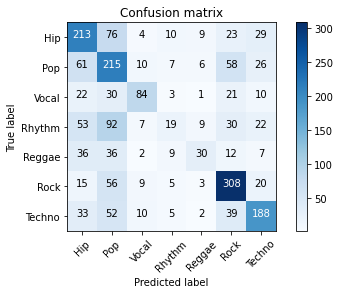

In [6]:
%%time
# Train
svm_classifier = SVC(C=10000.0, probability = True, class_weight=cl_weight, kernel='rbf')
svm_classifier.fit(x_train, y_train)

# Predict
pred_probs = svm_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/svm_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
